In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

np.random.seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from sklearn.mixture import GaussianMixture 
from sklearn.datasets import make_blobs

In [3]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [4]:
gm = GaussianMixture(n_components = 3, n_init=10, random_state = 42)
gm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Let's look at the parameters that the EM algorithm estimated:

In [5]:
gm.weights_

array([0.39032584, 0.20961444, 0.40005972])

In [6]:
gm.means_

array([[ 0.05145113,  0.07534576],
       [ 3.39947665,  1.05931088],
       [-1.40764129,  1.42712848]])

In [7]:
gm.covariances_

array([[[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]]])

In [8]:
#Lets check if the model converged
gm.converged_


True

In [9]:
#Yes it did. How many iterations did it take
gm.n_iter_

4

I can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, I will just use predict() method or the predict_proba() method:

In [10]:
gm.predict(X)

array([0, 0, 2, ..., 1, 1, 1], dtype=int64)

In [11]:
gm.predict_proba(X)

array([[9.76815996e-01, 2.31833274e-02, 6.76282339e-07],
       [9.82914418e-01, 1.64110061e-02, 6.74575575e-04],
       [7.52377580e-05, 1.99781831e-06, 9.99922764e-01],
       ...,
       [4.31902443e-07, 9.99999568e-01, 2.12540639e-26],
       [5.20915318e-16, 1.00000000e+00, 1.45002917e-41],
       [2.30971331e-15, 1.00000000e+00, 7.93266114e-41]])

Since this is a generative model, I can sample new instances from it and get their labes as well

In [12]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.86951041, -0.32742378],
       [ 0.29854504,  0.28307991],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [-1.04030781,  0.78655831]])

In [13]:
y_new

array([0, 0, 1, 1, 1, 2])

The are sampled seqientially rom each cluster

I want to see the decision boundaries (they are dashed lines) and density contours. This gives us a Voronoi diagram:

In [14]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [15]:
from matplotlib.colors import LogNorm


In [16]:
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

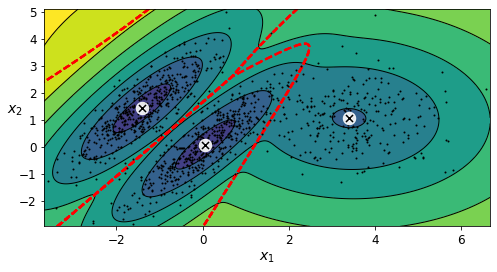

In [17]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

In [18]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [19]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)

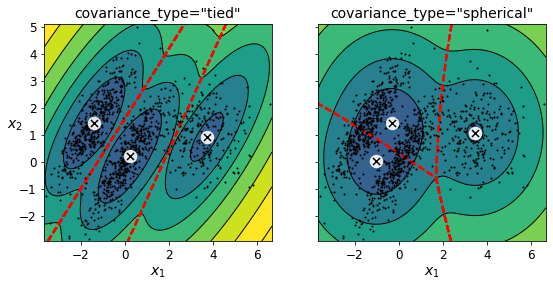

In [20]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)
plt.show()

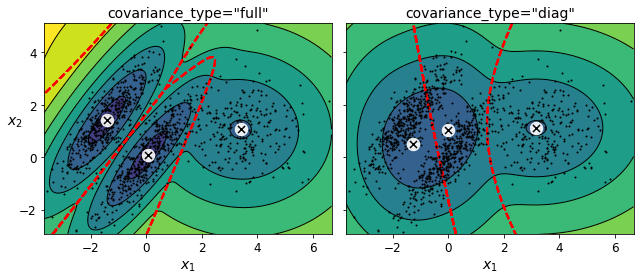

In [21]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

Anomaly detection

Gaussian Mixtures can be used for anomaly detection: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [22]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

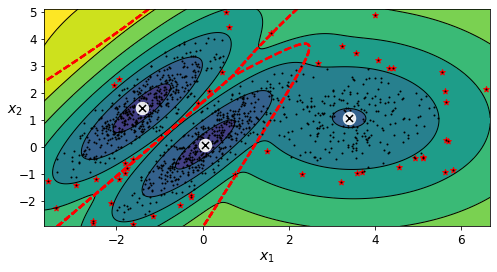

In [23]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()

Model selection
We cannot use the inertia or the silhouette score because they both assume that the clusters are spherical. Instead, we can try to find the model that minimizes a theoretical information criterion such as the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC):

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

$m$ is the number of instances.
$p$ is the number of parameters learned by the model.
$\hat L$ is the maximized value of the likelihood function of the model. This is the conditional probability of the observed data $\mathbf{X}$, given the model and its optimized parameters.
Both BIC and AIC penalize models that have more parameters to learn (e.g., more clusters), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data).

In [24]:
gm.bic(X)

8189.733705221635

In [25]:
gm.aic(X)

8102.508425106597

We could compute the BIC manually like this:

In [26]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [27]:
bic, aic

(8189.733705221635, 8102.508425106597)

In [28]:
n_params

17

Let's train Gaussian Mixture models with various values of $k$ and measure their BIC:

In [29]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [30]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

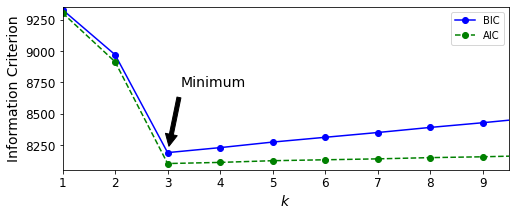

In [31]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

Let's search for best combination of values for both the number of clusters and the covariance_type hyperparameter:

In [70]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=3, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [71]:
best_k

10

In [72]:
best_covariance_type

'full'

In [35]:
import pandas as pd

#Here is dataset for usnerpvised anomaly detection obtained from havard ODDS:
    #https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OPQMVF
    
anom = pd.read_csv(r'C:\Users\olani\OneDrive\Documents\Data Science\Data Science projects\Machine Learning\Unsupervised Learning\Anomaly_dataset\aloi-unsupervised_ODDS_Harvard.csv',header=None)
    

In [36]:
anom1 = pd.DataFrame(anom)

In [37]:
anom1.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
           dtype='int64')

In [38]:
anom1.head

<bound method NDFrame.head of              0         1         2         3         4         5    6   \
0      0.872812  0.000005  0.000000  0.000036  0.000000  0.000000  0.0   
1      0.975206  0.000000  0.000000  0.000651  0.000000  0.000000  0.0   
2      0.963777  0.000000  0.000000  0.002005  0.000000  0.000000  0.0   
3      0.973246  0.000000  0.000000  0.000556  0.000000  0.000000  0.0   
4      0.960720  0.000000  0.000000  0.000656  0.000000  0.000000  0.0   
...         ...       ...       ...       ...       ...       ...  ...   
49995  0.967972  0.000319  0.000000  0.000520  0.000267  0.000002  0.0   
49996  0.974542  0.000472  0.000000  0.000723  0.000380  0.000007  0.0   
49997  0.980091  0.000671  0.000000  0.000845  0.000402  0.000011  0.0   
49998  0.981312  0.000830  0.000002  0.000285  0.000368  0.000041  0.0   
49999  0.982038  0.000886  0.000002  0.000133  0.000371  0.000043  0.0   

             7         8         9   ...        18        19   20        21  \
0 

In [39]:
anom1.shape

(50000, 28)

In [40]:
anom2 = anom1.replace(["n", "o"], [0,1])

In [41]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [42]:
anom2_scale = anom2.loc[ : , anom2.columns != 27]

In [43]:
scaler = StandardScaler() 

In [44]:
scaled_anom = scaler.fit_transform(anom2_scale) 

In [45]:
normalized_df1 = normalize(scaled_anom)

In [46]:
normalized_df1.shape

(50000, 27)

In [47]:
normalized_df1 = pd.DataFrame(normalized_df1) 

In [48]:
normalized_df1.head

<bound method NDFrame.head of              0         1         2         3         4         5         6   \
0     -0.196205 -0.135224 -0.045361 -0.119113 -0.139125 -0.084925 -0.021135   
1      0.591345 -0.146597 -0.049100 -0.091685 -0.150593 -0.091925 -0.022877   
2      0.566161 -0.165454 -0.055416 -0.010905 -0.169965 -0.103750 -0.025820   
3      0.572220 -0.145644 -0.048781 -0.096803 -0.149615 -0.091328 -0.022728   
4      0.522456 -0.160350 -0.053706 -0.099988 -0.164722 -0.100550 -0.025023   
...         ...       ...       ...       ...       ...       ...       ...   
49995  0.536650 -0.131186 -0.049291 -0.100016 -0.124345 -0.091826 -0.022966   
49996  0.579456 -0.121598 -0.048541 -0.086309 -0.111254 -0.089526 -0.022617   
49997  0.589073 -0.105769 -0.045933 -0.074754 -0.103157 -0.083862 -0.021401   
49998  0.592195 -0.097415 -0.044849 -0.105483 -0.105297 -0.077548 -0.021192   
49999  0.594272 -0.094292 -0.044608 -0.113372 -0.104525 -0.076713 -0.021079   

             7       

In [49]:
normalized_df[27] = anom2[27]

NameError: name 'normalized_df' is not defined

In [50]:
normalized_df1.columns

RangeIndex(start=0, stop=27, step=1)

In [51]:
normalized_df1.head

<bound method NDFrame.head of              0         1         2         3         4         5         6   \
0     -0.196205 -0.135224 -0.045361 -0.119113 -0.139125 -0.084925 -0.021135   
1      0.591345 -0.146597 -0.049100 -0.091685 -0.150593 -0.091925 -0.022877   
2      0.566161 -0.165454 -0.055416 -0.010905 -0.169965 -0.103750 -0.025820   
3      0.572220 -0.145644 -0.048781 -0.096803 -0.149615 -0.091328 -0.022728   
4      0.522456 -0.160350 -0.053706 -0.099988 -0.164722 -0.100550 -0.025023   
...         ...       ...       ...       ...       ...       ...       ...   
49995  0.536650 -0.131186 -0.049291 -0.100016 -0.124345 -0.091826 -0.022966   
49996  0.579456 -0.121598 -0.048541 -0.086309 -0.111254 -0.089526 -0.022617   
49997  0.589073 -0.105769 -0.045933 -0.074754 -0.103157 -0.083862 -0.021401   
49998  0.592195 -0.097415 -0.044849 -0.105483 -0.105297 -0.077548 -0.021192   
49999  0.594272 -0.094292 -0.044608 -0.113372 -0.104525 -0.076713 -0.021079   

             7       

In [52]:
# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df1) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
  
X_principal.head(2)

,P1,P2
0,0.458494,0.718538
1,-0.683918,0.060556


In [85]:
# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X1_principal = pca.fit_transform(anom2_scale) 
X1_principal = pd.DataFrame(X1_principal) 
X1_principal.columns = ['P1', 'P2'] 
  
X1_principal.head(2)

,P1,P2
0,0.030101,-0.024446
1,-0.079234,-0.000784


In [53]:
gm_john = GaussianMixture(n_components = 3, n_init=10, random_state = 42)
#gm_john.fit(X_principal)

gm.fit = gm_john.fit(normalized_df1)


In [86]:
#fit pca of original dataset

gm_john = GaussianMixture(n_components = 3, n_init=10, random_state = 42)
#gm_john.fit(X_principal)

gm.fit = gm_john.fit(X1_principal)

In [54]:
#Lets check if the model converged
gm_john.converged_


True

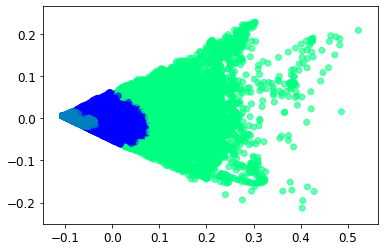

In [87]:
# Visualizing the clustering 
plt.scatter(X1_principal['P1'], X1_principal['P2'],  
           c = GaussianMixture(n_components = 3).fit_predict(X1_principal), cmap =plt.cm.winter, alpha = 0.6) 
plt.show() 

In [89]:
densities_anom = gm_john.score_samples(X1_principal)
density_threshold_anom = np.percentile(densities_anom, 4)
anomalies1 = normalized_df1[densities_anom < density_threshold]

In [90]:
len(densities_anom)

50000

In [91]:
anomalies1.shape

(96, 27)

In [92]:
#what percent of data are recognized as anomalies

perc_anom = anomalies1.shape[0]/normalized_df1.shape[0] #= 0.404%
perc_anom

0.00192

In [88]:
#bics and aics
gm_john.aic(X1_principal), gm_john.bic(X1_principal)

(-374561.0978786783, -374411.1616478433)

In [62]:
norm_pred = gm_john.predict(normalized_df1)

In [63]:
#norm_pred_frame = pd.DataFrame(pd.DataFrame(norm_pred))
anorm_pred_frame = pd.DataFrame(pd.DataFrame(anomalies1))

In [ ]:
#anoma1 = anomalies1[anomalies1[norm_pred]]

In [84]:
#Jupyer chokes on this. It was hangiing for a long time despite dropping the n_init from 10 to 5
gms_per_k1 = [GaussianMixture(n_components=k, n_init=5, random_state=42).fit(normalized_df1)
             for k in range(1, 11)]

IndentationError: unexpected indent (<ipython-input-84-fb7644b9d187>, line 3)

Lessons learned:
Using scaled_anom, anomalies are 40% of data set (bic = 71,557,472). Using normalized_df1 anomalies are 0.4% of data set (extremely low BIC at -5851030.98). 
With PCA of original dataset without scaling or normalization: anomalies are 0.0019% of data set (low BIC at -374561.0). The shape of the clusters are not radial at all.They look a pizza slice.

Let s try with Isolation Forest